In [223]:
import numpy as np
import dill as pickle
from collections import defaultdict, Counter
import re
from unidecode import unidecode
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import csv
from evlex_shared_scripts import *

In [224]:
# necessary files:
doreco_corpus = './files/corpus_doreco.p'
doreco_metadata = './files/doreco_files_metadata.csv'
nltk_stopwords_fn = 'stopwords.txt'

In [ ]:
genres = {'personal narrative','traditional narrative'}
#
raw_corpus = pickle.load(open(doreco_corpus, 'rb'))    
corpus = select_genres(raw_corpus, doreco_metadata, genres)
nltk_stopwords = set(map(lambda k : k.strip('\n'), open(nltk_stopwords_fn).readlines()))

In [ ]:
# data exploration
for d in corpus:
    print(d, sum(len(v) for v in corpus[d].values()))

### Preparation: infer text-to-morpheme and translation-to-gloss links

In [226]:
from itertools import product 
from scipy.stats import fisher_exact

def valid_g(gi):
    return not gi[0].isupper() and re.match('^[A-Z0-4.-=]+$', gi) == None and gi not in nltk_stopwords
    
def ft_gl_associations(corpus_doc):
    counts = defaultdict(lambda : Counter())
    i = 0
    cooc = set()
    f_verses, g_verses = defaultdict(lambda : set()), defaultdict(lambda : set())
    for file in corpus_doc:
        for l,elt in corpus_doc[file].items():
            gl = [m['G'] for m in elt['gloss']]
            gl_lin = {gy for gx in gl for gy in gx if valid_g(gy)}
            ft = get_lexical(get_mappable(elt['spc']))
            good_glin = list(filter(valid_g, gl_lin))
            for g in good_glin: g_verses[g].add(i)
            for f in ft: f_verses[f].add(i)
            cooc |= set(product(ft, good_glin))
            i += 1
    assoc = defaultdict(float)
    for f,g in cooc:
        assoc[f,g] = -np.log(fisher_exact([[len(f_verses[f] & g_verses[g]), len(f_verses[f]) - len(f_verses[f] & g_verses[g])],
                                        [len(g_verses[g]) - len(f_verses[f] & g_verses[g]), i - len(f_verses[f] | g_verses[g])]], 
                                       alternative='greater')[1])
    return assoc
    
def get_matches(l,v):
    return (i for i,e in enumerate(l) if e==v)
    
def get_ft_gl_alignment(spc, gl, assoc, verbose=True):
    glin, gidx = zip(*[(gy,(gi,gj)) for gi,gx in enumerate(gl) for gj,gy in enumerate(gx)])
    good_glin = set(filter(valid_g, glin))
    ft = get_lexical(get_mappable(elt['spc']))
    #
    if len(good_glin) == 0 or len(ft) == 0: return [], [], []
    #
    # get all string matched ft-gl pairs
    # (the ft is a part of the gl; tie-break gls by edit distance then association)
    #matched_gf = {f : {g : (-ed(g,f), assoc[f,g]) for g in good_glin if f in g} for f in ft }
    # matched =  [(max(gs, key = gs.get),f) for f,gs in matched_gf.items() if len(gs) > 0]
    #matched = [(g,f) for f,gs in matched_gf.items() for g in gs]
    matched = [(g,f) for g,f in product(good_glin, ft) if f in g]
    if verbose: print('>>>', good_glin)
    #
    # get all inferred relations
    # (among non-matched fts and gls, the ft and gl are each other's strongest associate)
    inferred = []
    available_ft = list(set(ft) - {f for g,f in matched})
    available_gl = list(good_glin - {g for g,f in matched})
    if len(available_ft) > 0 and len(available_gl) > 0:
        associations = np.zeros((len(available_ft),len(available_gl)))
        for fi,f in enumerate(available_ft):
            for gi,g in enumerate(available_gl):
                associations[fi,gi] = assoc[f,g]
        best_f_per_g = associations.argmax(0)
        best_g_per_f = associations.argmax(1)
        for fi,f in enumerate(available_ft):
            gi = best_g_per_f[fi]
            if best_f_per_g[gi] == fi and associations[fi,gi] > -np.log(0.001):
                inferred.append((available_gl[gi], f))
    # determine remaining missed list (any ft not in matched or inferred)
    missed = list(set(available_ft) - {f for g,f in inferred})
    #
    matched_idx = [(gidx[i], ft.index(f)) for g,f in matched for i in get_matches(glin, g)]
    inferred_idx = [(gidx[i], ft.index(f)) for g,f in inferred for i in get_matches(glin,g)]
    missed_idx = [ft.index(f) for f in missed]
    #
    # if verbose:#or len(missed) > (len(matched) + len(inferred))*2:
    #     print(good_ft, good_glin)
    #     print('+', ' '.join('%s|%s' % e for e in matched), '\n\t?', ' '.join('%s|%s' % e for e in inferred),
    #                   '\n\t-', ' '.join(missed))
    
    return matched_idx, inferred_idx, missed_idx

In [227]:
def get_char2tok(s):
    char2tok = { i : None for i in range(len(s))}
    ctr = 0
    for ci,c in enumerate(s):
        if c == '#': ctr += 1
        else: char2tok[ci] = ctr
    return char2tok
    
def get_tx_wr_alignment(tx, wr, verbose=False):
    clean_wr = '#'.join([''] + [unidecode(wi).lower() for wi in wr] + [''])
    clean_tx = '#'.join([''] + [unidecode(ti).lower() for ti in tx] + [''])
    #
    # get wagner-fisher matrix for edit distance
    matrix = np.zeros((len(clean_wr)+1, len(clean_tx)+1))
    trace = ([[[None,None,False]] + [[0,i,False] for i in range(len(clean_tx))]] + 
             [[[j,0,False]] + [[None,None,False] for i in range(len(clean_tx))] for j in range(len(clean_wr))])
    matrix[:,0] += np.arange(len(clean_wr)+1)
    matrix[0,:] += np.arange(len(clean_tx)+1)
    for i in range(1,len(clean_wr)+1):
        for j in range(1,len(clean_tx)+1):
            
            ins_val = matrix[i-1,j] + 1
            del_val = matrix[i,j-1] + 1
            link_val = matrix[i-1,j-1] + 2*int(clean_wr[i-1] != clean_tx[j-1])
            
            if link_val <= min(del_val,ins_val): matrix[i,j] = link_val; trace[i][j] = [i-1,j-1,clean_wr[i-1] == clean_tx[j-1]]
            elif del_val <= ins_val: matrix[i,j] = del_val; trace[i][j] = [i,j-1,False]
            else: matrix[i,j] = ins_val; trace[i][j] = [i-1,j,False]
    #
    # determine character alignment
    alignment, next_alignment = [trace[-1][-1]], trace[-1][-1]
    while next_alignment != [None,None,False]:
        if next_alignment[0]-1 >= 0 and next_alignment[1]-1 >= 0:
            alignment = [[next_alignment[0],next_alignment[1],next_alignment[2]]] + alignment
        next_alignment = trace[next_alignment[0]][next_alignment[1]]
    # determine word alignment
    tx_wr_alignment_dict = {}
    wr_char2tok = get_char2tok(clean_wr)
    tx_char2tok = get_char2tok(clean_tx)
    for aw,at,match in alignment:
        if match and wr_char2tok[aw] != None and tx_char2tok[at] != None:
            tx_wr_alignment_dict[tx_char2tok[at]-1] = tx_wr_alignment_dict.get(tx_char2tok[at]-1, set()) | {wr_char2tok[aw]-1}
    tx_wr_alignment = [(t,w) for t in tx_wr_alignment_dict for w in tx_wr_alignment_dict[t]]
    if verbose: print('WR:', clean_wr, '\nTX:', clean_tx, '\nCH:', alignment, '\nTW:', tx_wr_alignment)
    return tx_wr_alignment

In [228]:
def create_quads(MT, GF, tx, wr, mr, spc, gl):
    ft = get_lexical(get_mappable(spc))
    for (t,m) in MT:
        for gx,gf in enumerate(GF[:2]):
            for ((gi,gj),f) in gf:
                if m == gi:
                    try: txi = tx[t]
                    except: print(tx, wr, mr, '|', t, MT)
                    yield {'status' : ('matched' if gx == 0 else 'inferred'),
                           'tx' : tx[t],
                           'mr' : mr[m][gj],
                           'gl' : gl[gi][gj],
                           'ft' : ft[f]}

In [229]:
# BITEXT FUNCTIONS
good_pos = {'NOUN','ADJ','VERB'}
excluded_lemmas = {'be', 'other', 'have', 'let', 'one', 'lot', 'same', 'such', 't', 's'}

def get_mappable(parse):
    parenthetical_level = 0
    new_parse = []
    for w in parse:
        if w['text'] in '[(':
            parenthetical_level += 1
        if parenthetical_level == 0:
            new_parse.append(w)
        if w['text'] in ')]':
            parenthetical_level -= 1
        if parenthetical_level < 0:
            # print('  ' + ' '.join([w['text'] for w in parse]))
            parenthetical_level = 0
    return new_parse

def get_lexical(parse):
    return list(set(w['lemma'] for w in parse if (w['pos'] in good_pos and 
                                                  w['lemma'] not in excluded_lemmas and 
                                                  not is_actually_aux(w, parse))))

In [230]:
from datetime import datetime

good_doculects = []
matched_coverage = []
inferred_coverage = []
#
observed = { doc : {} for doc in corpus }
for doc in corpus:
    assoc = ft_gl_associations(corpus[doc])
    fg_matches = [] # for tracking N matches
    i = 0
    for f in corpus[doc]:
        for l in corpus[doc][f]:
            elt = corpus[doc][f][l]
            tx, wr = re.sub('#', '|', elt['tx']).split(), [m['w'] for m in elt['gloss']] # <-- take RE out once extraction rerun
            mr = [m['M'] for m in elt['gloss']]
            gl, spc = [m['G'] for m in elt['gloss']], elt['spc']
            if not (len(wr) == 0 or next((False for g in gl if g != []),True)):
                tx_wr_alignments = get_tx_wr_alignment(tx, wr, False)
                ft_gl_alignments = get_ft_gl_alignment(spc, gl, assoc, False)
                fg_matches.append(ft_gl_alignments) # for tracking N matches
                observed[doc][i] = list(create_quads(tx_wr_alignments, ft_gl_alignments, tx, wr, mr, spc, gl))
            i += 1
    if len(fg_matches) == 0: continue
    # code below is for bookkeeping coverage per doculect
    cy = sum(map(lambda k : len(k), list(zip(*fg_matches))[0])) 
    c2 = sum(map(lambda k : len(k), list(zip(*fg_matches))[1]))
    cn = sum(map(lambda k : len(k), list(zip(*fg_matches))[2]))
    if (cy+c2+cn) == 0: continue
    good_doculects.append(doc[:8])
    matched_coverage.append(cy/(cy+c2+cn))
    inferred_coverage.append((cy+c2)/(cy+c2+cn))
    print('%s (%s): matched: %.2f  inferred: %.2f' % 
          (doc[:8].upper(), datetime.now(), matched_coverage[-1], inferred_coverage[-1]))
    

APAH1238 (2024-03-25 11:18:26.458524): matched: 0.42  inferred: 0.62
ARAP1274 (2024-03-25 11:18:36.579380): matched: 0.59  inferred: 0.72
BAIN1259 (2024-03-25 11:18:41.230961): matched: 0.54  inferred: 0.74


/tmp/ipykernel_89842/791622622.py:24: RuntimeWarning: divide by zero encountered in log
  assoc[f,g] = -np.log(fisher_exact([[len(f_verses[f] & g_verses[g]), len(f_verses[f]) - len(f_verses[f] & g_verses[g])],


BEJA1238 (2024-03-25 11:18:44.765563): matched: 0.67  inferred: 0.84
BORA1263 (2024-03-25 11:19:33.811185): matched: 0.44  inferred: 0.70
CABE1245 (2024-03-25 11:19:38.456999): matched: 0.64  inferred: 0.73
CASH1254 (2024-03-25 11:19:41.497000): matched: 0.59  inferred: 0.73
DOLG1241 (2024-03-25 11:19:58.619386): matched: 0.74  inferred: 0.87
EVEN1259 (2024-03-25 11:20:05.355120): matched: 0.49  inferred: 0.66
GOEM1240 (2024-03-25 11:20:13.837669): matched: 0.75  inferred: 0.90
GORO1270 (2024-03-25 11:20:15.020179): matched: 0.64  inferred: 0.82
HOCH1243 (2024-03-25 11:20:23.021921): matched: 0.54  inferred: 0.71
JEHA1242 (2024-03-25 11:20:27.434568): matched: 0.64  inferred: 0.81
KAKA1265 (2024-03-25 11:20:30.421072): matched: 0.52  inferred: 0.71
KAMA1351 (2024-03-25 11:20:44.954782): matched: 0.73  inferred: 0.91
KOMN1238 (2024-03-25 11:20:56.720903): matched: 0.54  inferred: 0.75
MOVI1243 (2024-03-25 11:20:59.594342): matched: 0.57  inferred: 0.80
NGAL1292 (2024-03-25 11:20:59.9795

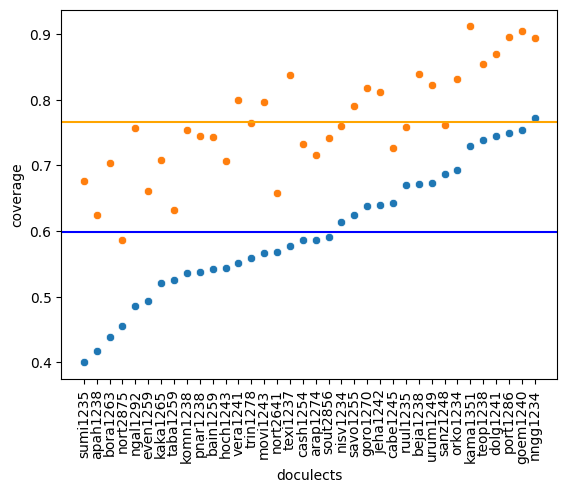

In [231]:
# coverage: proportion of lexical ft that have lexical gloss matches
# some upper bound: grammaticized elements.
df_coverage = pd.DataFrame({'doculects' : good_doculects,
                            'coverage matched' : matched_coverage, 
                            'coverage inferred' : inferred_coverage})
df_coverage = df_coverage.sort_values(by=['coverage matched', 'coverage inferred'])

sns.scatterplot(data=df_coverage, x='doculects', y='coverage matched')
sns.scatterplot(data=df_coverage, x='doculects',y='coverage inferred')
plt.axhline(np.mean(df_coverage['coverage matched']), c = 'blue')
plt.axhline(np.mean(df_coverage['coverage inferred']), c = 'orange')
plt.ylabel('coverage')
x = plt.xticks(rotation=90)

### Gather all <marker, tx-index, ft-index> triplets

In [235]:
def get_extracted(corpus, observed, verbose=False):
    extracted = {doc : {} for doc in corpus}
    for doc in corpus:
        txs = [list(map(lambda w : unidecode(w).lower(), elt['tx'].split())) 
               for f in corpus[doc] for l,elt in corpus[doc][f].items()]
        indices = [(f,l) for f in corpus[doc] for l,elt in corpus[doc][f].items()]
        if observed[doc] == {}: continue
        #tes, te_words = pickle.load(open('./pickles/tes_%s.p' % doc,'rb'))
        # tes, te_words = merge_similar_tes(doc) <<--- this should be done prior to the evaluation script
        for wi,w in enumerate((list(tes))):
            if verbose and (wi % 50 == 0 or (wi < 50 and wi % 5 == 0)): 
                print(' ', w, te_words[w].keys())
            for te, hits in tes[w].items():
                ctr = Counter([wi.strip('^$') for h in hits for wi in te_words[w][te] if wi.strip('^$') in txs[h]])
                for h in filter(lambda h : h in observed[doc], hits):
                    #tx = next((wi for wi in te_words[w][te] if wi.strip('^$') in txs[h]),None)
                    tx = max(filter(lambda wi : wi in ctr, txs[h]), key = lambda wi : ctr[wi], default=None)
                    if tx == None: print(w, te, h,txs[h])
                    new_m = [{'marker' : te, 'tx' : tx, 'ft' : w}]
                    extracted[doc][h] = extracted[doc].get(h, []) + new_m
        print(doc, len(observed[doc]), len(extracted[doc]))
    return extracted

In [236]:
extracted = get_extracted(corpus, observed, False)

apah1238.csv 677 489
arap1274.csv 3050 2803
bain1259.csv 881 850
beja1238.csv 5760 4993
bora1263.csv 3157 3029
cabe1245.csv 261 256
cash1254.csv 1215 1188
dolg1241.csv 2189 2150
even1259.csv 2269 2145
goem1240.csv 1518 1495
goro1270.csv 550 515
hoch1243.csv 714 693
jeha1242.csv 769 669
kaka1265.csv 964 952
kama1351.csv 8793 8366
komn1238.csv 6293 5236
movi1243.csv 1655 1498
ngal1292.csv 277 223
nisv1234.csv 1675 1540
nngg1234.csv 3525 3038
nort2641.csv 834 828
nort2875.csv 513 417
orko1234.csv 1380 1249
pnar1238.csv 652 634
port1286.csv 1124 1090
ruul1235.csv 515 503
sanz1248.csv 404 398
savo1255.csv 739 716
sout2856.csv 1545 1514
sumi1235.csv 85 66
taba1259.csv 632 622
teop1238.csv 1962 1832
texi1237.csv 2817 2617
trin1278.csv 1584 1558
urum1249.csv 2295 2241
vera1241.csv 1583 1529


### Evaluation experiment I: token-level (ft-tx) matches


In [237]:
def extract_eval_mappings(doc, extracted, observed, ft_gl_alignment):
    per_mr, per_ex = defaultdict(lambda : []),  defaultdict(lambda : [])
    #
    all_hits = set(extracted[doc].keys()) | set(observed[doc].keys())
    for h in all_hits:
        #
        obs_h = observed[doc][h] if h in observed[doc] else []
        obs_h = list(filter(lambda o : ft_gl_alignment == 'inferred' or o['status'] == 'matched', obs_h))
        ext_h = extracted[doc][h] if h in extracted[doc] else []
        #
        obs_ft_anchors = defaultdict(lambda : [])
        for o in obs_h:
            obs_ft_anchors[o['ft']].append(o)
        #
        mapped_o2e = set()
        for e in ext_h:
            e_tx = unidecode(e['tx'].strip('^$')).lower()
            obs_matches = obs_ft_anchors[e['ft']] if e['ft'] in obs_ft_anchors else []
            o_tx = set(map(lambda k : unidecode(k['tx']).lower(), obs_matches))
            if len(o_tx) == 0: continue
            correct = e_tx in o_tx
            #
            o_mr = next((o['mr'] for o in obs_matches),None)
            per_ex[e['marker']].append((h, o_mr, correct, e['ft']))
            if o_mr != None: per_mr[o_mr].append((h, e['marker'], correct, next((o['ft'] for i in obs_matches),None)))
            mapped_o2e.add(e['ft'])
        for ft in set(obs_ft_anchors) - mapped_o2e: # retrieves unmapped O
            o_mr = next((o['mr'] for o in obs_ft_anchors[ft]),None)
            per_mr[o_mr].append((h, None, False, ft))
    return per_mr, per_ex

def get_iso_score(dic, level = 'micro'):
    comparisons = []
    for k,v in dic.items():
        ctr = Counter(map(lambda k : k[1], filter(lambda k : k[2], v)))
        comparisons.extend([max(ctr.values(),default=0)/len(v)] * (len(v) if level == 'micro' else 1))
    return np.mean(comparisons)
    
def eval_doc(doc, extracted, observed, corpus, ft_gl_alignment = 'observed', verbose=False):
    #
    #indices = [(f,l) for f in corpus[doc] for l in corpus[doc][f]]
    #f,l = indices[h]
    #elt = corpus[doc][f][l]
    #
    per_mr, per_ex = extract_eval_mappings(doc, extracted, observed, ft_gl_alignment)
    n_exp = sum(len(v) for k,v in per_ex.items())
    n_obs = sum(len(v) for k,v in per_mr.items())
    #
    micro_token_precision = np.mean(list(x[2] for ex in per_ex for x in per_ex[ex]))
    if np.isnan(micro_token_precision): return None, per_mr, per_ex
    micro_token_recall    = np.mean(list(x[2] for mr in per_mr for x in per_mr[mr]))
    macro_token_precision = np.mean([np.mean([x[2] for x in per_ex[ex]]) for ex in per_ex])
    macro_token_recall    = np.mean([np.mean([x[2] for x in per_mr[mr]]) for mr in per_mr])
    #
    micro_type_precision  = get_iso_score(per_ex, 'micro')
    macro_type_precision  = get_iso_score(per_ex, 'macro')
    micro_type_recall     = get_iso_score(per_mr, 'micro')
    macro_type_recall     = get_iso_score(per_mr, 'macro')
    #
    if verbose: print('%s (N=%d ~ %d)\t%.2f (%.2f | i %.2f %.2f) %.2f (%.2f | i %.2f %.2f)' % 
          (doc, n_exp, n_obs, micro_token_precision, macro_token_precision, micro_type_precision, macro_type_precision,
           micro_token_recall, macro_token_recall, micro_type_recall, macro_type_recall))
    entry = {'doculect' : doc, 'N expected' : n_exp, 'N observed' : n_obs,
             'micro token precision' : micro_token_precision, 'macro token precision' : macro_token_precision,
             'micro token recall' : micro_token_recall, 'macro token recall' : macro_token_recall,
             'micro type precision' : micro_type_precision, 'macro type precision' : macro_type_precision,
             'micro type recall' : micro_type_recall, 'macro type recall' : macro_type_recall}
    return entry, per_mr, per_ex
       

In [238]:
builder, per_mr, per_ex = [], {}, {}
for doc in corpus:
    e, per_mr_d, per_ex_d = eval_doc(doc, extracted, observed, corpus, 'matched', True)  
    if e == None: continue
    per_ex[doc] = per_ex_d
    per_mr[doc] = per_mr_d
    builder.append(e)
extraction_results = pd.DataFrame(builder)

apah1238.csv (N=348 ~ 350)	0.84 (0.74 | i 0.76 0.72) 0.84 (0.77 | i 0.77 0.75)
arap1274.csv (N=3858 ~ 3910)	0.93 (0.83 | i 0.61 0.68) 0.92 (0.85 | i 0.85 0.81)
bain1259.csv (N=1156 ~ 1160)	0.90 (0.74 | i 0.76 0.67) 0.90 (0.77 | i 0.86 0.75)


/home/barend/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/barend/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


beja1238.csv (N=5937 ~ 6126)	0.95 (0.84 | i 0.78 0.78) 0.92 (0.86 | i 0.81 0.82)
bora1263.csv (N=5101 ~ 5161)	0.89 (0.65 | i 0.83 0.62) 0.88 (0.70 | i 0.81 0.67)
cabe1245.csv (N=517 ~ 519)	0.76 (0.59 | i 0.55 0.49) 0.76 (0.63 | i 0.74 0.63)
cash1254.csv (N=2148 ~ 2175)	0.86 (0.68 | i 0.78 0.64) 0.85 (0.72 | i 0.80 0.69)
dolg1241.csv (N=5807 ~ 5868)	0.89 (0.66 | i 0.75 0.60) 0.88 (0.70 | i 0.84 0.68)
even1259.csv (N=2399 ~ 2412)	0.90 (0.72 | i 0.66 0.60) 0.90 (0.78 | i 0.87 0.76)
goem1240.csv (N=4484 ~ 4521)	0.94 (0.81 | i 0.91 0.79) 0.93 (0.84 | i 0.90 0.83)
goro1270.csv (N=826 ~ 833)	0.91 (0.79 | i 0.66 0.64) 0.90 (0.85 | i 0.88 0.84)
hoch1243.csv (N=1298 ~ 1311)	0.79 (0.63 | i 0.68 0.58) 0.78 (0.68 | i 0.70 0.66)
jeha1242.csv (N=1030 ~ 1034)	0.92 (0.81 | i 0.72 0.70) 0.92 (0.84 | i 0.89 0.83)
kaka1265.csv (N=1543 ~ 1550)	0.89 (0.72 | i 0.84 0.70) 0.89 (0.76 | i 0.87 0.74)
kama1351.csv (N=13817 ~ 13919)	0.97 (0.88 | i 0.92 0.86) 0.96 (0.89 | i 0.92 0.86)
komn1238.csv (N=5556 ~ 5611)	0

In [239]:
extraction_results['baseline token precision'] = [baseline_token_precision[doc] for doc in extraction_results.doculect]

In [240]:
extraction_results.head()

,doculect,N expected,N observed,micro token precision,macro token precision,micro token recall,macro token recall,micro type precision,macro type precision,micro type recall,macro type recall,baseline token precision
0,apah1238.csv,348,350,0.841954,0.735868,0.837143,0.772604,0.755747,0.716729,0.774286,0.746908,0.251525
1,arap1274.csv,3858,3910,0.928979,0.828778,0.916624,0.854601,0.606791,0.683752,0.854476,0.809970,0.375493
2,bain1259.csv,1156,1160,0.903114,0.736145,0.900000,0.774350,0.759516,0.668605,0.856034,0.748038,0.241513
3,beja1238.csv,5937,6126,0.946101,0.841644,0.916912,0.859304,0.781034,0.781638,0.807215,0.817431,0.447276
4,bora1263.csv,5101,5161,0.886493,0.650197,0.876187,0.695762,0.825916,0.617810,0.809146,0.665057,0.131810


P = 0.888  R = 0.881 | baseP = 0.190


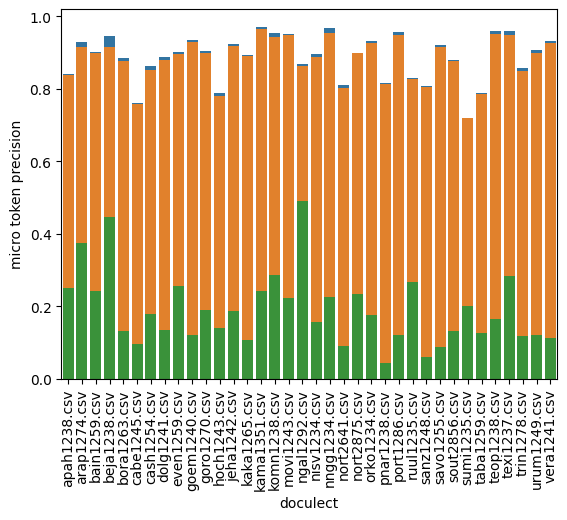

In [242]:
print('P = %.3f  R = %.3f | baseP = %.3f' % (np.nanmean(extraction_results['micro token precision']),
                              np.nanmean(extraction_results['micro token recall']),
                              np.nanmean(extraction_results['baseline token precision'])))
sns.barplot(data=extraction_results, x='doculect', y='micro token precision')
sns.barplot(data=extraction_results, x='doculect', y='micro token recall')
sns.barplot(data=extraction_results, x='doculect', y='baseline token precision')
x = plt.xticks(rotation=90)

P = 0.766  R = 0.841


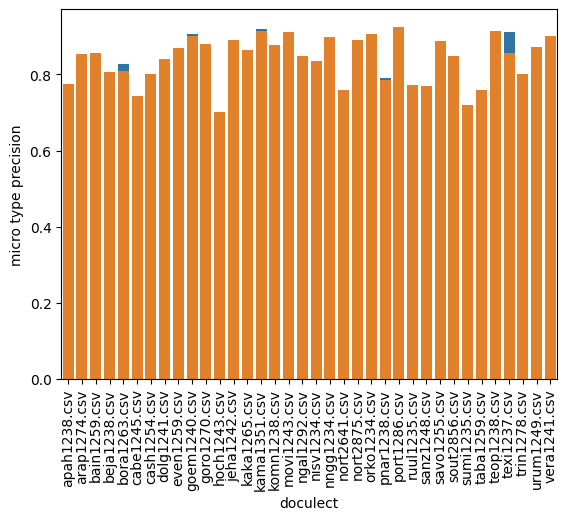

In [214]:
print('P = %.3f  R = %.3f' % (np.nanmean(extraction_results['micro type precision']),
                              np.nanmean(extraction_results['micro type recall'])))
sns.barplot(data=extraction_results, x='doculect', y='micro type precision')
sns.barplot(data=extraction_results, x='doculect', y='micro type recall')
x = plt.xticks(rotation=90)

In [217]:
baseline_token_precision = {}
baseline_token_recall = {}
for doc in corpus:
    accs = []
    for file in corpus[doc]:
        for line,elt in corpus[doc][file].items():
            lex = get_lexical(get_mappable(elt['spc']))
            wrd = elt['tx'].split()
            accs.extend([1/len(wrd)] * len(lex))
    baseline_token_precision[doc] = np.mean(accs)

In [103]:
def get_most_frequent_errors(dic, corpus_d, topn=5, exn=5):
    errors = defaultdict(lambda : [])
    indices = [(f,l) for f in corpus_d for l in corpus_d[f]]
    tot_cases = sum(len(V) for V in dic.values())
    for k,V in dic.items():
        for h,x,correct,alt in V:
            if not correct:
                errors[k,x,alt].append(h)
    for ei,(error,hits) in enumerate(sorted(errors.items(), key = lambda k : -len(k[1]))[:topn]):
        n = len(hits)
        prop =  n/tot_cases
        print('#%d\t%s\tN=%d\tProp=%.3f' % (ei, error, n, prop))
        if n > 10 or prop > 0.01:
            for i in hits[:exn]:
                f,l = indices[i]
                elt =  corpus_d[f][l]
                print('\t', i, f, l)
                print('\t>%s\n\t%s\n\t%s\n\t%s\n\t%s\n\t' % 
                      (elt['tx'],' '.join(['-'.join(g['M']) for g in elt['gloss']]), 
                                ' '.join(['-'.join(g['G']) for g in elt['gloss']]), elt['ft'],
                                 ' '.join(get_lexical(get_mappable(elt['spc'])))))